## Lake package (LAK) Package problem 2

This is the lake package example problem (test 2) from the
Lake Package documentation (Merritt and Konikow, 2000).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
import shapefile as shp
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-lak-p02"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 5  # Number of layers
nrow = 27  # Number of rows
ncol = 17  # Number of columns
top = 200.0  # Top of the model ($ft$)
botm_str = "102., 97., 87., 77., 67."  # Bottom elevations ($ft$)
strt = 115.0  # Starting head ($ft$)
k11 = 30.0  # Horizontal hydraulic conductivity ($ft/d$)
k33 = 30.0  # Vertical hydraulic conductivity ($ft/d$)
ss = 3e-4  # Specific storage ($1/d$)
sy = 0.2  # Specific yield (unitless)
H1 = 160.0  # Constant head on left side of model ($ft$)
H2 = 140.0  # Constant head on right side of model ($ft$)
recharge = 0.0116  # Aereal recharge rate ($ft/d$)
etvrate = 0.0141  # Maximum evapotranspiration rate ($ft/d$)
etvdepth = 15.0  # Evapotranspiration extinction depth ($ft$)
lak_strt = 130.0  # Starting lake stage ($ft$)
lak_etrate = 0.0103  # Lake evaporation rate ($ft/d$)
lak_bedleak = 0.1  # Lakebed leakance ($1/d$)

# Parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]

# Static temporal data used by TDIS file
tdis_ds = ((1500.0, 200, 1.005),)

# define delr and delc
delr = np.array(
    [
        250.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        500.0,
        500.0,
        500.0,
        500.0,
        500.00,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        250.0,
    ]
)
delc = np.array(
    [
        250.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        500.0,
        500.0,
        500.0,
        500.0,
        500.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        500.0,
        500.0,
        500.0,
        500.0,
        500.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        1000.0,
        250.0,
    ]
)

# Define dimensions
extents = (0.0, delr.sum(), 0.0, delc.sum())
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

# Load the idomain arrays
fname = "lakes-01.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:a74ded5357aa667b9df793847e5f8f41",
)
lake_map = np.ones(shape3d, dtype=int) * -1
lake_map[0, :, :] = np.loadtxt(fpath, dtype=int) - 1
fname = "lakes-02.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:7830e5223c958c35be349a3be24a60a3",
)
lake_map[1, :, :] = np.loadtxt(fpath, dtype=int) - 1

# create linearly varying evapotranspiration surface
xlen = delr.sum() - 0.5 * (delr[0] + delr[-1])
x = 0.0
s1d = H1 * np.ones(ncol, dtype=float)
for idx in range(1, ncol):
    x += 0.5 * (delr[idx - 1] + delr[idx])
    frac = x / xlen
    s1d[idx] = H1 + (H2 - H1) * frac
surf = np.tile(s1d, (nrow, 1))
surf[lake_map[0, :, :] > -1] = botm[0] - 2
surf[lake_map[1, :, :] > -1] = botm[1] - 2

# Constant head boundary conditions
chd_spd = []
for k in range(nlay):
    chd_spd += [[k, i, 0, H1] for i in range(nrow)]
    chd_spd += [[k, i, ncol - 1, H2] for i in range(nrow)]

# LAK Package
lak_time_conv = 86400.0
lak_len_conv = 3.28081
lak_outlets = [
    [0, 0, -1, "manning", 114.85, 5.0, 0.05, 8.206324419006205e-4],
    [1, 1, -1, "manning", 109.4286, 5.0, 0.05, 9.458197164349258e-4],
]
lak_spd = [
    [0, "rainfall", recharge],
    [0, "evaporation", lak_etrate],
    [1, "rainfall", recharge],
    [1, "evaporation", lak_etrate],
]

# SFR package
sfr_pakdata = [
    [
        0,
        0,
        1,
        4,
        1000,
        5,
        0.001103448,
        123.94827,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
    [
        1,
        0,
        2,
        4,
        1000,
        5,
        0.001103448,
        122.84483,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        2,
        0,
        3,
        4,
        1000,
        5,
        0.001103448,
        121.74138,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        3,
        0,
        3,
        5,
        1000,
        5,
        0.001103448,
        120.63793,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        4,
        0,
        3,
        6,
        500,
        5,
        0.001103448,
        119.81035,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        5,
        0,
        3,
        7,
        750,
        5,
        0.001103448,
        119.12069,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        6,
        0,
        4,
        7,
        1000,
        5,
        0.001103448,
        118.15517,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        7,
        0,
        5,
        7,
        1000,
        5,
        0.001103448,
        117.05173,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
    [
        8,
        0,
        11,
        8,
        1000,
        5,
        0.000820632,
        114.43968,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
    [
        9,
        0,
        12,
        8,
        1000,
        5,
        0.000820632,
        113.61905,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        10,
        0,
        13,
        9,
        559,
        5,
        0.000820632,
        112.97937,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        11,
        0,
        13,
        9,
        559,
        5,
        0.000820632,
        112.52063,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        12,
        0,
        14,
        9,
        1000,
        5,
        0.000820632,
        111.88095,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        13,
        0,
        15,
        9,
        1000,
        5,
        0.000820632,
        111.06032,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
    [
        14,
        0,
        21,
        9,
        1000,
        5,
        0.00094582,
        108.95569,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
    [
        15,
        0,
        22,
        9,
        750,
        5,
        0.00094582,
        108.1281,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        16,
        0,
        22,
        10,
        500,
        5,
        0.00094582,
        107.53696,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        17,
        0,
        22,
        11,
        1000,
        5,
        0.00094582,
        106.82759,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        18,
        0,
        22,
        12,
        1000,
        5,
        0.00094582,
        105.88177,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        19,
        0,
        22,
        13,
        1000,
        5,
        0.00094582,
        104.93595,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        20,
        0,
        22,
        14,
        1000,
        5,
        0.00094582,
        103.99014,
        0.5,
        0.5,
        0.050000001,
        2,
        1,
        0,
    ],
    [
        21,
        0,
        22,
        15,
        1000,
        5,
        0.00094582,
        103.04431,
        0.5,
        0.5,
        0.050000001,
        1,
        1,
        0,
    ],
]

sfr_conn = [
    [0, -1],
    [1, 0, -2],
    [2, 1, -3],
    [3, 2, -4],
    [4, 3, -5],
    [5, 4, -6],
    [6, 5, -7],
    [7, 6],
    [8, -9],
    [9, 8, -10],
    [10, 9, -11],
    [11, 10, -12],
    [12, 11, -13],
    [13, 12],
    [14, -15],
    [15, 14, -16],
    [16, 15, -17],
    [17, 16, -18],
    [18, 17, -19],
    [19, 18, -20],
    [20, 19, -21],
    [21, 20],
]

sfr_spd = [[0, "inflow", 691200.0]]

# MVR package
mvr_paks = [
    ["SFR-1"],
    ["LAK-1"],
]
mvr_spd = [
    ["SFR-1", 7, "LAK-1", 0, "FACTOR", 1.0],
    ["LAK-1", 0, "SFR-1", 8, "FACTOR", 1.0],
    ["SFR-1", 13, "LAK-1", 1, "FACTOR", 1.0],
    ["LAK-1", 1, "SFR-1", 14, "FACTOR", 0.5],
]

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, newtonoptions="newton", save_flows=True
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=np.ones(shape3d, dtype=int),
        top=top,
        botm=botm,
    )
    obs_file = f"{sim_name}.gwf.obs"
    csv_file = obs_file + ".csv"
    obslist = [
        ["A", "head", (0, 3, 3)],
        ["B", "head", (0, 13, 8)],
        ["C", "head", (0, 23, 13)],
    ]
    obsdict = {csv_file: obslist}
    flopy.mf6.ModflowUtlobs(
        gwf, filename=obs_file, print_input=False, continuous=obsdict
    )

    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=etvrate, depth=etvdepth)
    (
        idomain_wlakes,
        pakdata_dict,
        lak_conn,
    ) = flopy.mf6.utils.get_lak_connections(
        gwf.modelgrid,
        lake_map,
        bedleak=lak_bedleak,
    )
    lak_packagedata = []
    for key in pakdata_dict.keys():
        lak_packagedata.append([key, lak_strt, pakdata_dict[key]])
    lak = flopy.mf6.ModflowGwflak(
        gwf,
        pname="LAK-1",
        time_conversion=lak_time_conv,
        length_conversion=lak_len_conv,
        mover=True,
        print_stage=True,
        nlakes=2,
        noutlets=len(lak_outlets),
        packagedata=lak_packagedata,
        connectiondata=lak_conn,
        outlets=lak_outlets,
        perioddata=lak_spd,
    )
    obs_file = f"{sim_name}.lak.obs"
    csv_file = obs_file + ".csv"
    obs_dict = {
        csv_file: [
            ("lake1", "stage", (0,)),
            ("lake2", "stage", (1,)),
        ]
    }
    lak.obs.initialize(
        filename=obs_file, digits=10, print_input=True, continuous=obs_dict
    )
    gwf.dis.idomain = idomain_wlakes
    flopy.mf6.ModflowGwfsfr(
        gwf,
        pname="SFR-1",
        time_conversion=86400.000,
        length_conversion=3.28081,
        mover=True,
        print_stage=True,
        print_flows=True,
        nreaches=len(sfr_pakdata),
        packagedata=sfr_pakdata,
        connectiondata=sfr_conn,
        perioddata=sfr_spd,
    )
    flopy.mf6.ModflowGwfmvr(
        gwf,
        maxmvr=4,
        maxpackages=2,
        packages=mvr_paks,
        perioddata=mvr_spd,
    )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)


def plot_grid(gwf, silent=True):
    sim_ws = os.path.join(workspace, sim_name)

    # create lake array
    ilake = gwf.dis.idomain.array
    ilake[ilake == 0] = 100
    ilake[ilake == 1] = 0
    ilake[ilake == 100] = 1
    for k in range(nlay):
        for i in range(16, nrow):
            for j in range(ncol):
                if ilake[k, i, j] == 1:
                    ilake[k, i, j] = 2

    # get edges and centers of cells
    xedges, yedges = gwf.modelgrid.xyedges[0], gwf.modelgrid.xyedges[1]
    xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]

    # create sfr network
    poly0 = [
        [xcenters[4], yedges[1]],
        [xcenters[4], ycenters[4]],
        [xcenters[7], ycenters[4]],
        [xcenters[7], yedges[6]],
    ]
    poly1 = [
        [xcenters[8], yedges[11]],
        [xcenters[8], yedges[13]],
        [xcenters[9], yedges[14]],
        [xcenters[9], yedges[16]],
    ]
    poly2 = [
        [xcenters[9], yedges[21]],
        [xcenters[9], ycenters[22]],
        [xedges[16], ycenters[22]],
    ]
    parts = [poly0, poly1, poly2]
    shape_pth = os.path.join(workspace, sim_name, "sfr.shp")
    w = shp.Writer(target=shape_pth, shapeType=shp.POLYLINE)
    w.field("no", "C")
    w.line([poly0])
    w.record(["1"])
    w.line([poly1])
    w.record(["2"])
    w.line([poly2])
    w.record(["3"])
    w.close()
    sfr = shp.Reader(shape_pth)

    # load the observations
    lak_results = gwf.lak.output.obs().data

    # create MODFLOW 6 head object
    hobj = gwf.output.head()

    # create MODFLOW 6 cell-by-cell budget object
    cobj = gwf.output.budget()

    kstpkper = hobj.get_kstpkper()

    head = hobj.get_data(kstpkper=kstpkper[0])
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0],
        gwf,
    )

    # add lake stage to heads
    head[ilake == 1] = lak_results["LAKE1"][-1]
    head[ilake == 2] = lak_results["LAKE2"][-1]

    # observation locations
    p1 = (xcenters[3], ycenters[3])
    p2 = (xcenters[8], ycenters[13])
    p3 = (xcenters[13], ycenters[23])

    # lake text locations
    pl1 = (xcenters[8], ycenters[8])
    pl2 = (xcenters[8], ycenters[18])

    with styles.USGSMap():
        fig = plt.figure(
            figsize=(4, 6.9),
            tight_layout=True,
        )
        plt.axis("off")

        nrows, ncols = 10, 1
        axes = [fig.add_subplot(nrows, ncols, (1, 8))]

        for idx, ax in enumerate(axes):
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(nrows, ncols, (9, 10)))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        mm.plot_bc("CHD", color="cyan")
        for shape in sfr.shapeRecords():
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            ax.plot(x, y, color="#3BB3D0", lw=1.5, zorder=1)
        mm.plot_inactive(color_noflow="#5DBB63")
        mm.plot_grid(lw=0.5, color="black")
        cv = mm.contour_array(
            head,
            levels=np.arange(120, 160, 5),
            linewidths=0.75,
            linestyles="-",
            colors="blue",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        ax.plot(p1[0], p1[1], marker="o", mfc="red", mec="black", ms=4)
        ax.plot(p2[0], p2[1], marker="o", mfc="red", mec="black", ms=4)
        ax.plot(p3[0], p3[1], marker="o", mfc="red", mec="black", ms=4)
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.add_text(
            ax,
            "A",
            x=p1[0] + 150,
            y=p1[1] + 150,
            transform=False,
            bold=False,
            color="red",
            ha="left",
            va="bottom",
        )
        styles.add_text(
            ax,
            "B",
            x=p2[0] + 150,
            y=p2[1] + 150,
            transform=False,
            bold=False,
            color="red",
            ha="left",
            va="bottom",
        )
        styles.add_text(
            ax,
            "C",
            x=p3[0] + 150,
            y=p3[1] + 150,
            transform=False,
            bold=False,
            color="red",
            ha="left",
            va="bottom",
        )
        styles.add_text(
            ax,
            "Lake 1",
            x=pl1[0],
            y=pl1[1],
            transform=False,
            italic=False,
            color="white",
            ha="center",
            va="center",
        )
        styles.add_text(
            ax,
            "Lake 2",
            x=pl2[0],
            y=pl2[1],
            transform=False,
            italic=False,
            color="white",
            ha="center",
            va="center",
        )
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="#5DBB63",
            mec="black",
            markeredgewidth=0.5,
            label="Lake boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="black",
            markeredgewidth=0.5,
            label="Constant-head boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=1.5,
            color="#3BB3D0",
            label="Stream network",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="o",
            ms=4,
            mfc="red",
            mec="black",
            markeredgewidth=0.5,
            label="Observation well",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0.75,
            ls="-",
            color="blue",
            label=r"Head contour, $ft$",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        styles.graph_legend(ax, loc="lower center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_lak_results(gwf, silent=True):
    with styles.USGSPlot():
        # load the observations
        lak_results = gwf.lak.output.obs().data
        gwf_results = gwf.obs[0].output.obs().data

        dtype = [
            ("time", float),
            ("LAKE1", float),
            ("LAKE2", float),
            ("A", float),
            ("B", float),
            ("C", float),
        ]

        results = np.zeros((lak_results.shape[0] + 1), dtype=dtype)
        results["time"][1:] = lak_results["totim"]
        results["LAKE1"][0] = lak_strt
        results["LAKE1"][1:] = lak_results["LAKE1"]
        results["LAKE2"][0] = lak_strt
        results["LAKE2"][1:] = lak_results["LAKE2"]
        results["A"][0] = strt
        results["A"][1:] = gwf_results["A"]
        results["B"][0] = strt
        results["B"][1:] = gwf_results["B"]
        results["C"][0] = strt
        results["C"][1:] = gwf_results["C"]

        # create the figure
        fig, axes = plt.subplots(
            ncols=1,
            nrows=2,
            sharex=True,
            figsize=(6.3, 4.3),
            constrained_layout=True,
        )

        ax = axes[0]
        ax.set_xlim(0, 1500)
        ax.set_ylim(110, 130)
        ax.plot(
            results["time"],
            results["LAKE1"],
            lw=0.75,
            ls="--",
            color="black",
            label="Lake 1 stage",
        )
        ax.plot(
            results["time"],
            results["LAKE2"],
            lw=0.75,
            ls="-.",
            color="black",
            label="Lake 2 stage",
        )
        ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500])
        ax.set_yticks([110, 115, 120, 125, 130])
        ax.set_ylabel("Lake stage, in feet")
        styles.graph_legend(ax, loc="upper right")
        styles.heading(ax, idx=0)

        ax = axes[1]
        ax.set_xlim(0, 1500)
        ax.set_ylim(110, 160)
        ax.plot(
            results["time"],
            results["A"],
            lw=0.75,
            ls="-",
            color="0.5",
            label="Point A",
        )
        ax.plot(
            results["time"],
            results["B"],
            lw=0.75,
            ls="-",
            color="black",
            label="Point B",
        )
        ax.plot(
            results["time"],
            results["C"],
            lw=0.75,
            ls="-.",
            color="black",
            label="Point C",
        )
        ax.set_xticks([0, 250, 500, 750, 1000, 1250, 1500])
        ax.set_xlabel("Simulation time, in days")
        ax.set_yticks([110, 120, 130, 140, 150, 160])
        ax.set_ylabel("Head, in feet")
        styles.graph_legend(ax, loc="upper left")
        styles.heading(ax, idx=1)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    gwf = sim.get_model(sim_name)
    plot_grid(gwf, silent=silent)
    plot_lak_results(gwf, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 8872.37 ms


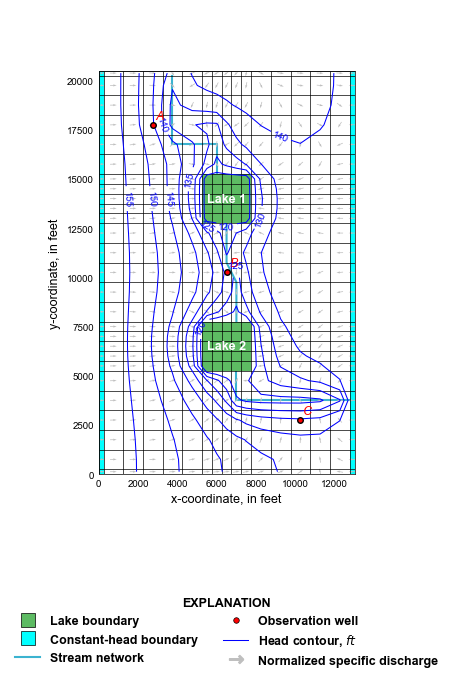

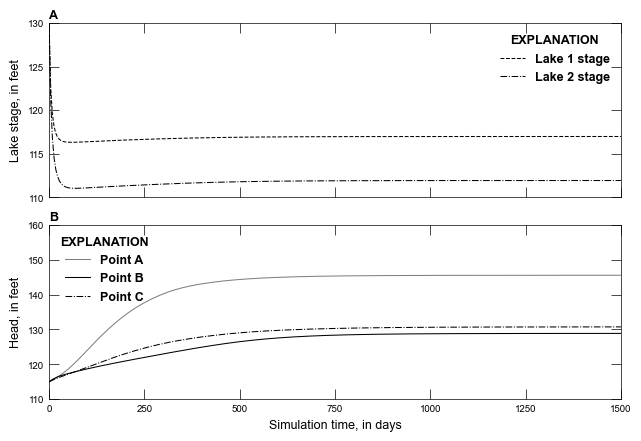

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()